In [103]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

from utils import *
from config import Configs
from models.TSSCD import TSSCD_FCN, TSSCD_Unet, TSSCD_TransEncoder
import torch.nn.functional as F

device = device_on()
configs = Configs()
plt.rcParams['font.family'] = ['Arial']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False

Uisng cuda device


In [104]:
# province, lat_lon = 'ZJ', [121.6767133, 30.0035682]   # for Example Herbicide
# province, lat_lon = 'ZJ', [121.2472183, 30.3695776]   # for Example
# province, lat_lon = 'SH', [121.81218, 31.6342] # for Example

# province, lat_lon = 'SD', [119.26149, 37.83372]
# province, lat_lon = 'ZJ', [121.18391023607681, 30.370969528768967]
# province, lat_lon = 'SH', [121.84308, 31.61774] 
# province, lat_lon = 'ZJ', [121.23043, 28.27489]   # tide
province, lat_lon = 'FJ', [119.95224, 26.79633]
# province, lat_lon = 'JS', [120.482807, 33.836398]
# province, lat_lon = 'FJ', [117.42213, 23.93001]
# province, lat_lon = 'FJ', [119.64785, 26.02422]
# province, lat_lon = 'SD', [117.60098, 38.76842]
# province, lat_lon = 'JS', [120.65606, 33.50901]
# province, lat_lon = 'SH', [121.80098, 31.63056]
# province, lat_lon = 'GDGX', [109.661282, 21.563297]

radius, model_name = 500, 'TSSCD_Unet'

# date2display = ['2021-08-01', '2021-11-01', '2023-08-01', '2023-11-01', '2024-08-01']
# date2display = ['2021-07-01', '2021-10-01','2022-06-01', '2022-09-01', '2023-08-01']
date2display = ['2021-09-01', '2022-10-01', '2023-10-01', '2024-07-01', '2024-10-01']
# date2display = ['2024-08-01','2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01']

In [105]:
def scaleMinMax(x):
    return((x - np.nanmin(x))/(np.nanmax(x) - np.nanmin(x)))

In [106]:
# LOAD MODEL
model_names = ['TSSCD_FCN', 'TSSCD_Unet', 'TSSCD_TransEncoder']
model_instances = {
    'TSSCD_FCN': TSSCD_FCN(configs.input_channels, configs.classes, configs.model_hidden),
    'TSSCD_Unet': TSSCD_Unet(configs.input_channels, configs.classes, configs.model_hidden),
    'TSSCD_TransEncoder': TSSCD_TransEncoder(configs.input_channels, configs.classes, configs.Transformer_dmodel)
}

model = model_instances[model_name]
model_state_dict = torch.load(os.path.join('models\\model_data', model_name, '1001.pth'), map_location='cuda', weights_only=True)
model = model.to(device)
model.load_state_dict(model_state_dict)
model.eval()

TSSCD_Unet(
  (embedding): Conv1d(12, 128, kernel_size=(1,), stride=(1,))
  (layer1): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): ReLU(inplace=True)
    (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): ReLU(inplace=True)
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dil

In [107]:
directory = os.path.join('.\\TimeSeriesImages\\SA_blocks_clipped&mosaic', province)

dates = pd.date_range(start='2020-01-01', end='2024-12-01', freq='MS') # Dates
imgs = [os.path.join(directory, date.strftime('%Y_%m.tif')) for date in dates] # Time Series Images

lc_clrmap = {
    0: ['#3ABF99', 'S. alterniflora'],       # Spartina alterniflora
    1: ['#808080', 'Tidal flats'],       # bare flats
    2: ['#069DFF', 'Open water'],       # water
    3: ['#6D65A3', 'Herbicide-treated litter'],       # herbicide
    4: ['red', 'other vegetation']
}

In [108]:
from utils import *

# ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'VV', 'VH']
pixel_ts_values = [extract_time_series_data(lat_lon, img) for img in imgs]
pixel_ts_values = np.stack(pixel_ts_values, axis=1) # 12 × 60
model_input = np.expand_dims(pixel_ts_values, axis=0) # 1 × 12 × 60
model_input = torch.Tensor(standardization(model_input)).to(device)
with torch.no_grad():
    if isinstance(model, TSSCD_TransEncoder):
        preds = model(model_input.permute(0, 2, 1))
        preds = preds.permute(0, 2, 1)
    else:
        preds = model(model_input)

class_probs = F.softmax(preds, dim=1)[0].cpu().numpy()
preds = torch.argmax(input=preds, dim=1).cpu().numpy()
org_output = preds

print(f'before filter:\n {preds[0]}')
preds = MajorityFilter(preds, kernel_size=3)[0]  # temporal filter
print(f'after filter:\n {preds}\n')
ndvi = (pixel_ts_values[6, :] - pixel_ts_values[2, :]) / (pixel_ts_values[6, :] + pixel_ts_values[2, :] + 1e-6)
vv, vh = pixel_ts_values[10, :], pixel_ts_values[11, :]

change_points = np.where(preds[:-1] != preds[1:])[0] + 1
cd = dates[np.concatenate([[0], change_points, [-1]])]
lcc = preds[np.concatenate([[0], change_points])]

output = extract_change_event_from_pixel(lcc, change_points)
print(f'lcc:\t {lcc}\ncd:\t {change_points}')
events = ['Invasion', 'Mowing 1st', 'Mowing 2nd', 'Waterlogging', 'Herbicide control', 'Recurring', 'No change', 'WL_fast']
print(f'output: {output}')
print(f'change dates:\t {[date.strftime('%Y-%m') for date in dates[change_points]]};\nland cover:\t {[lc_clrmap[i][1] for i in lcc]};')
hped_event = [(event, output[i]) for i, event in enumerate(events) if output[i] != 99]
hped_event = sorted(hped_event, key=lambda x: x[1])
hped_event = [t[0] for t in hped_event]
print(f'happened event:\t {hped_event}')

before filter:
 [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 1]
after filter:
 [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 1]

lcc:	 [1 2 1 2 1 2 1]
cd:	 [ 7 29 45 50 52 57]
output: [99, 99, 99, 99, 99, 99, 99, 99]
change dates:	 ['2020-08', '2022-06', '2023-10', '2024-03', '2024-05', '2024-10'];
land cover:	 ['Tidal flats', 'Open water', 'Tidal flats', 'Open water', 'Tidal flats', 'Open water', 'Tidal flats'];
happened event:	 []


In [109]:
# load image data
img4display = [dates.get_loc(pd.to_datetime(idx)) for idx in date2display]

lc_img, imgs_output_path = list(), f'.\\display\\'
for img in [imgs[int(i)] for i in img4display]:
    ds = gdal.Open(img)
    geotransform = ds.GetGeoTransform()
    
    width, height = ds.RasterXSize, ds.RasterYSize
    x, y = int((lat_lon[0] - geotransform[0]) / geotransform[1]), int((lat_lon[1] - geotransform[3]) / geotransform[5])
    x_min, x_max = max(x - radius, 0), min(x + radius, width)
    y_min, y_max = max(y - radius, 0), min(y + radius, height)
    
    data = ds.ReadAsArray(x_min, y_min, x_max - x_min, y_max - y_min)
    rgb = np.stack([data[6], data[2], data[1]]) / 10000
    for i in range(3):
        rgb[i] = scaleMinMax(rgb[i])
    lc_img.append(rgb.transpose(1, 2, 0))
    ds = None

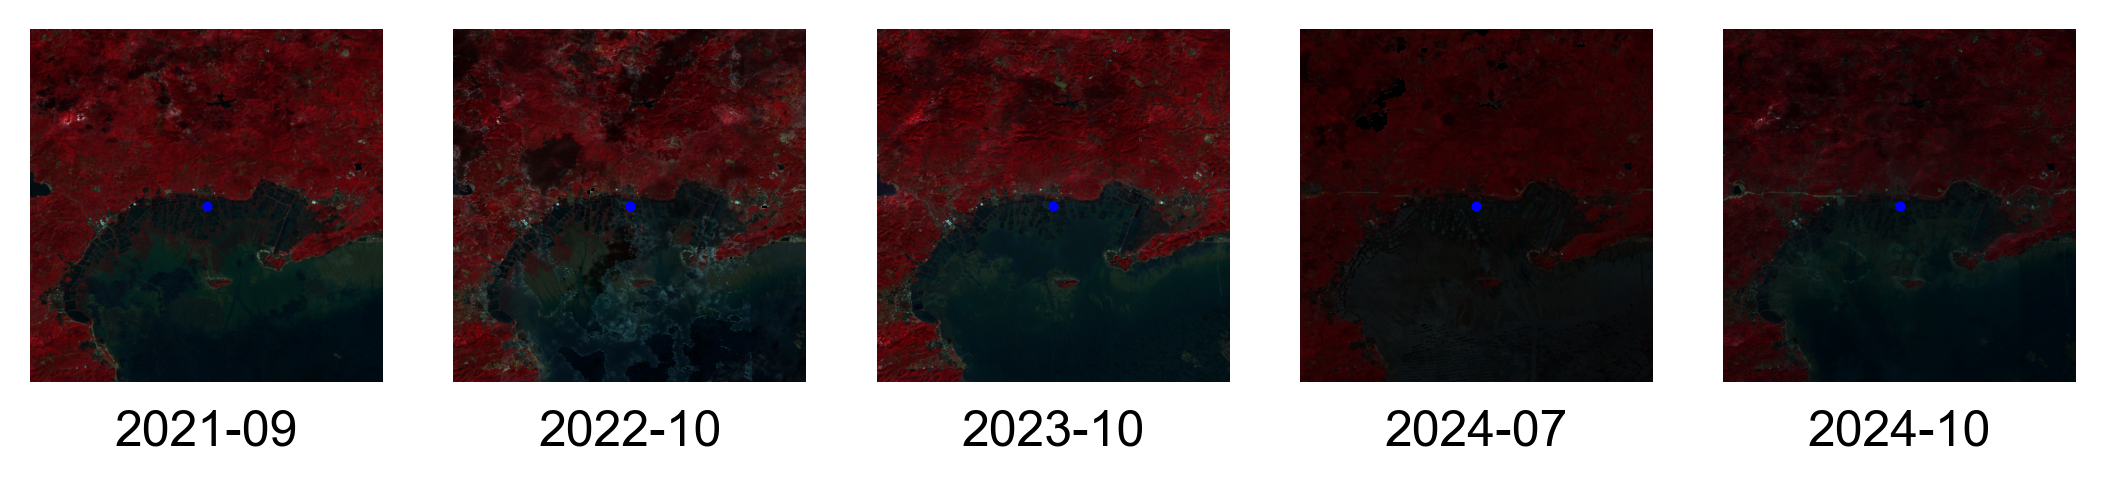

In [110]:
spacing = 0.2
num_axes = len(img4display)
fig = plt.figure(figsize=(8 + (num_axes - 1) * spacing, 2), dpi=300)
gs = GridSpec(1, num_axes, width_ratios=[1] * num_axes, wspace=spacing)

axes = []
for i in range(num_axes):
    axes.append(fig.add_subplot(gs[i]))
    
gamma = 1.2
for i, (img, date) in enumerate(zip(lc_img, img4display)):
    img = np.power(img, gamma)
    axes[i].imshow(img)
    axes[i].set_title(dates[date].strftime('%Y-%m'), y=-0.25)
    axes[i].scatter(radius, radius, marker='o', s=2, c='blue',zorder=99)
    axes[i].axis('off')
plt.show()

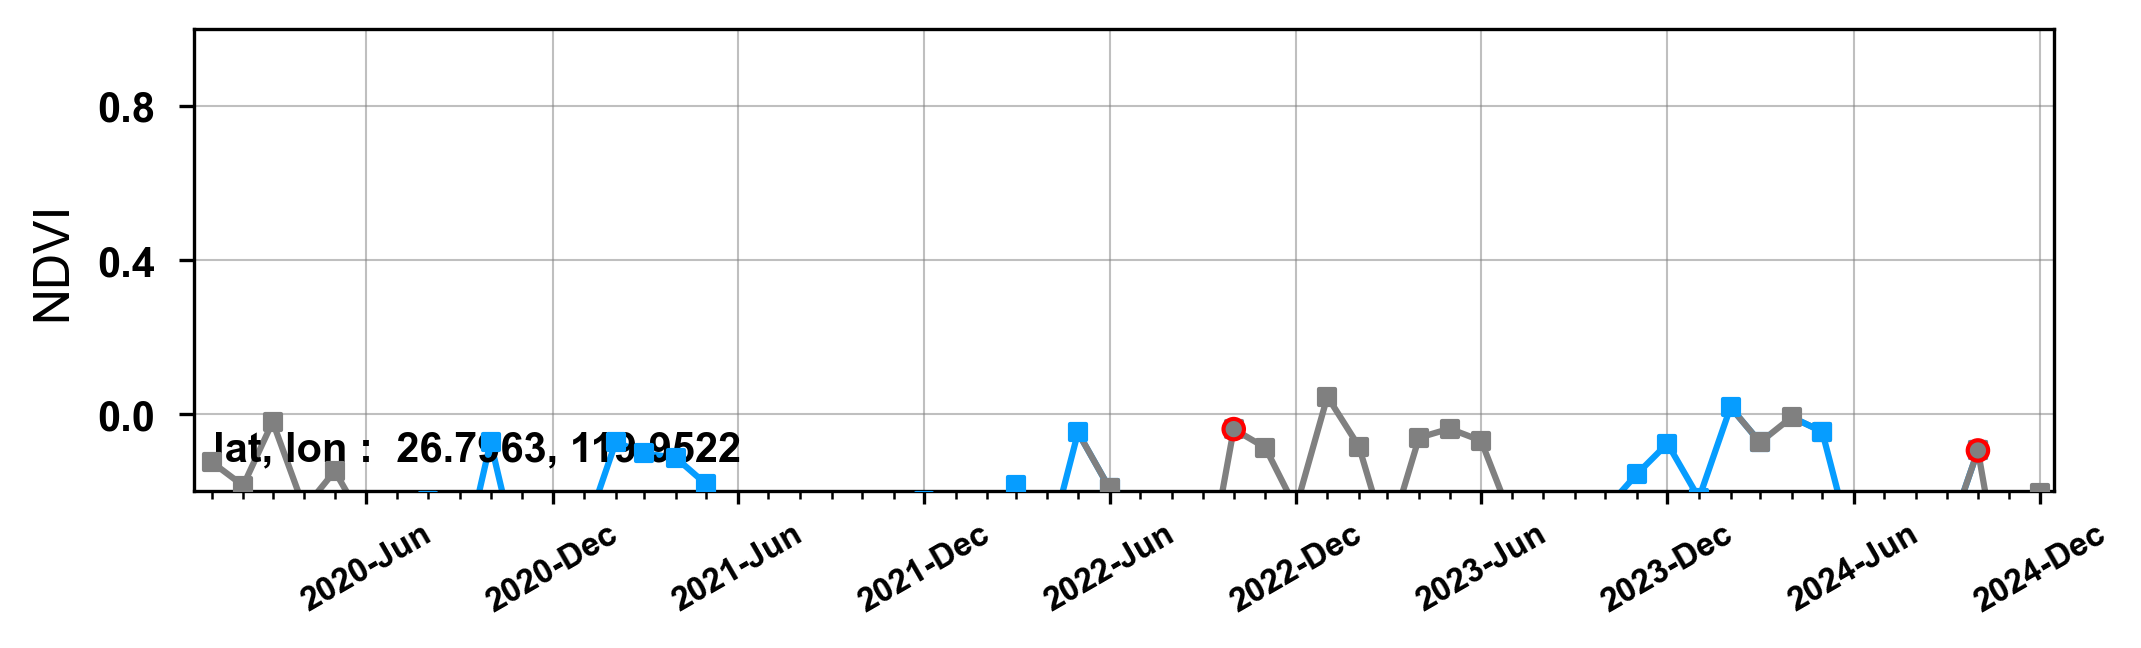

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=300)
ax.set_ylim(-0.2, 1)
# ax.set_ylim(-0.8, 1)
ax.set_ylabel('NDVI', fontsize=12, labelpad=5)

from matplotlib.lines import Line2D
legend_elements, added_labels = list(), set()

# Plot NDVI
for i in range(len(cd) - 1):
    idx_start, idx_end = dates.get_loc(cd[i]), dates.get_loc(cd[i + 1]) + 1
    color, label = lc_clrmap[lcc[i]][0], lc_clrmap[lcc[i]][1]
    if label not in added_labels:
        legend_elements.append(
            Line2D([0], [0], color=color, marker='s', linestyle='-', markersize=5, linewidth=1.5, label=label)
        )
        added_labels.add(label)
    ax.scatter(dates[idx_start: idx_end], ndvi[idx_start: idx_end], c=color, s=16, marker='s',zorder=99)
    idx_start = 1 if idx_start == 0 else idx_start
    ax.plot(dates[idx_start - 1: idx_end], ndvi[idx_start - 1: idx_end], c=color, linestyle='-')

# Event text & vline
# for i, e in zip(range(0, len(change_points)), hped_event):
#     ax.axvline(x=dates[change_points[i]] - pd.Timedelta(days=15), 
#                linestyle='--', alpha=1, zorder=0, linewidth=1.5,
#                color='#96CCCB')
#     ax.text(
#         cd[i+1],
#         # which event-text lower
#         0.83 if i in [0, 2] else 1.08,   # SH example
#         hped_event[i],
#         ha='center', va='bottom',
#         fontsize=12, fontweight='bold',
#         transform=ax.get_xaxis_transform(),
#         bbox=dict(
#             facecolor='white',   # 背景色（白色）
#             edgecolor='black',   # 边框色（黑色）
#             linewidth=0.3,       # 边框线宽
#             boxstyle='round',    # 边框样式（圆角矩形）
#             pad=0.3             # 文本与边框的内边距
#             )
#         )
    
# Plot selected Dates
for date in date2display:
    idx = dates.get_loc(date)
    ax.scatter(dates[idx], ndvi[idx], s=24, facecolors='none', edgecolors='red', marker='o',zorder=100)

    
from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.yaxis.set_major_locator(MultipleLocator(0.4))

ax.tick_params(axis='x', rotation=30, labelsize=8, length=3, labelbottom=True, which='major')
ax.tick_params(axis='y', pad=6)
ax.set_xlim(pd.Timestamp('2019-12-15'), pd.Timestamp('2024-12-15'))

# location: lat, lon
ax.text(
    0.01, 0.05,
    f'lat, lon :  {lat_lon[1]:.4f}, {lat_lon[0]:.4f}',
    ha='left', va='bottom',
    fontsize=10,
    fontweight='bold',
    transform=ax.transAxes
)

# ax.legend(
#     handles=legend_elements,
#     loc='upper right',
#     bbox_to_anchor=(1, 1),
#     ncol=8,
#     frameon=False,
#     columnspacing=0.5
# )

ax.grid(which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
# plt.setp(
#     ax.yaxis.get_ticklabels(),
#     ha='right',
#     va='center',
# )

# No x-axis label
# ax.tick_params(axis='x', rotation=90, labelsize=8, length=3, labelbottom=False, which='major')
# ax.tick_params(axis='x', rotation=90, labelsize=8, length=3, labelbottom=False, which='minor')
plt.show()

org_output: [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 1]
round_mask_float: [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
(1, 300)


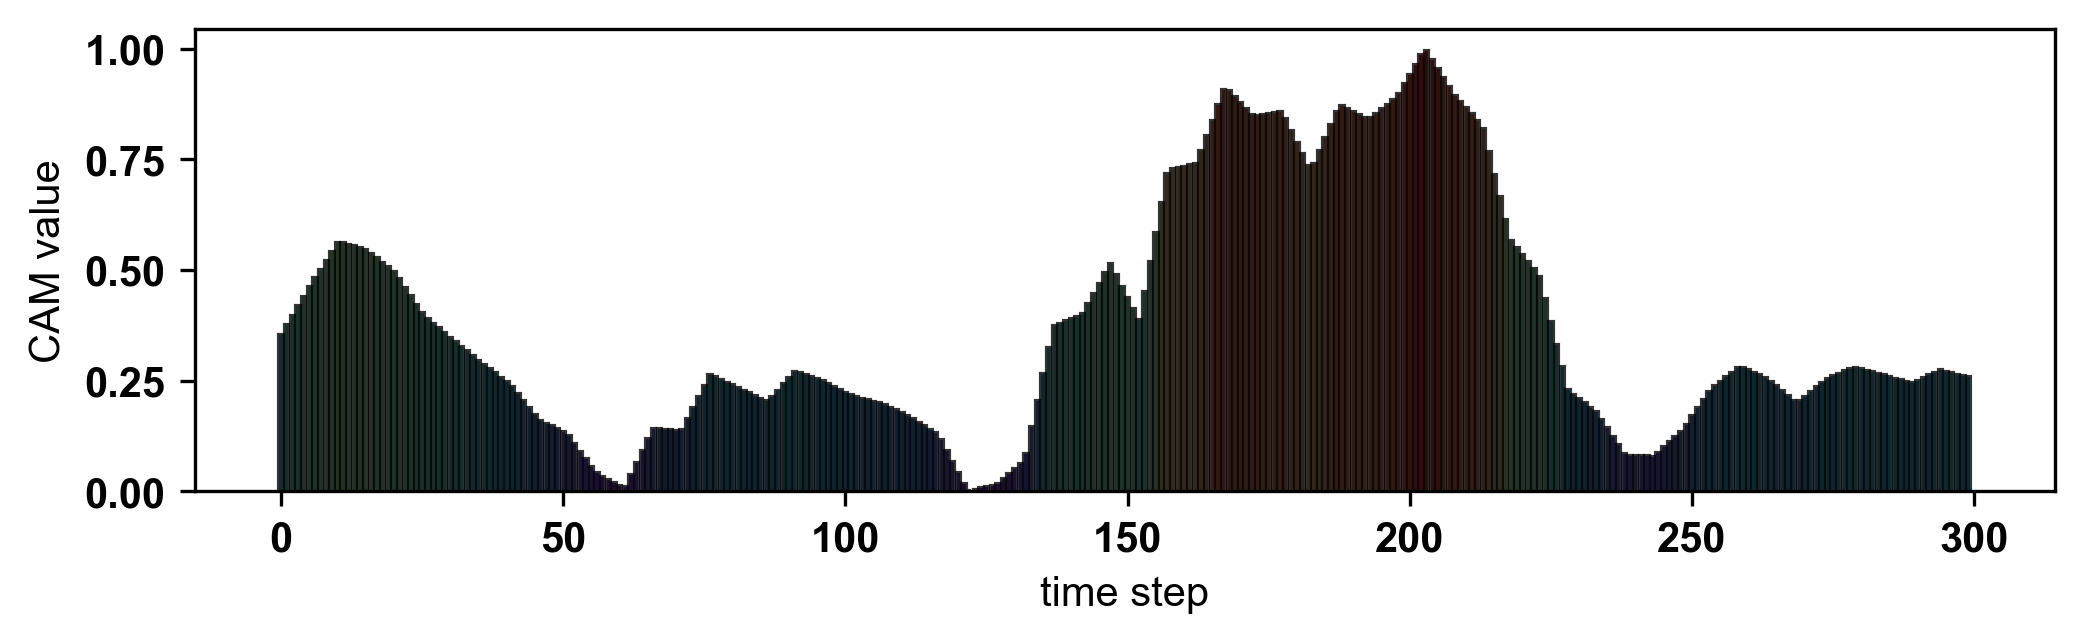

In [112]:

from GradCAM import GradCAM

round_category = 1
round_mask = org_output[0]
print(f'org_output: {org_output[0]}')
round_mask_uint8 = 255 * np.uint8(round_mask == round_category)
round_mask_float = np.float32(round_mask == round_category)
print(f'round_mask_float: {round_mask_float}')

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask).squeeze()
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
 
    def __call__(self, model_output):
        return (model_output[self.category, :] * self.mask).sum()

target_layers = [model.upconv_layer1[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
targets = [SemanticSegmentationTarget(round_category, round_mask_float)]

grayscale_cam = cam(input_tensor=model_input, targets=targets, size=len(round_mask) * 5)[0]
print(grayscale_cam[0].shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=300)
# ax.set_ylim(-0.2, 1.2)
# ax.set_ylabel('probabilities distribution', fontsize=12)

lgd_elements = list()

# SAR backscatter
# for ts, clr, label in zip(list([vv, vh]), ['red', 'blue'], ['VV', 'VH']):
#     ax.scatter(dates, ts, c=clr, s=12, marker='o',zorder=99)
#     ax.plot(dates, ts, color=clr, linewidth=1.5)
#     lgd_elements.append(
#         Line2D([0], [0], color=clr[0], marker='s', linestyle='-', markersize=5, linewidth=1.5, label=label)
#     )

# Output probability
# for class_prob, clr in zip(class_probs, lc_clrmap.values()):
#     ax.plot(dates, class_prob, color=clr[0], linewidth=1.5)
#     ax.scatter(dates, class_prob, c=clr[0], s=12, marker='o',zorder=99)
#     lgd_elements.append(
#         Line2D([0], [0], color=clr[0], marker='s', linestyle='-', markersize=5, linewidth=1.5, label=clr[1])
#     )

# ax.legend(
#     handles=lgd_elements,
#     loc='upper right',
#     bbox_to_anchor=(1, 1.2),
#     ncol=8,
#     frameon=False,
#     columnspacing=0.5
# )

# Grad-CAM heatmap
heatmap = grayscale_cam[0].flatten()
time_steps = range(len(heatmap))
norm = plt.Normalize(heatmap.min(), heatmap.max())
colors = plt.cm.rainbow(norm(heatmap))
ax.bar(
    x=time_steps,
    height=heatmap,
    width=0.6,
    color=colors,
    alpha=0.8,
    edgecolor='black'
)
ax.set_xlabel('time step', fontsize=10)
ax.set_ylabel('CAM value', fontsize=10)

plt.show()
